# NBEATS With Exogeneous Variables Forecasting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# If needed:
# !pip install neuralforecast numpy pandas scikit-learn matplotlib

from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx

## Configuration

In [2]:
ALPHA     = 0.05      # 95% PI
CAL_SIZE  = 60        # last N points of TRAIN for conformal calibration
INPUT_SIZE = 180
MAX_STEPS  = 300
LR         = 1e-3
SEED       = 42

## Load Data and Do Some Feature Engineering

In [3]:
train = pd.read_csv('DailyDelhiClimateTrain.csv', parse_dates=['date'])
test  = pd.read_csv('DailyDelhiClimateTest.csv',  parse_dates=['date'])

cols = ['date', 'humidity', 'meantemp']
train = train[cols].copy()
test  = test[cols].copy()

for c in ['humidity', 'meantemp']:
    train[c] = pd.to_numeric(train[c], errors='coerce')
    test[c]  = pd.to_numeric(test[c],  errors='coerce')

# Fill NaNs for exogenous; drop rows only if target missing
train['meantemp'] = train['meantemp'].interpolate(limit_direction='both').ffill().bfill()
test['meantemp']  = test['meantemp'].interpolate(limit_direction='both').ffill().bfill()
train = train.dropna(subset=['humidity']).reset_index(drop=True)
test  = test.dropna(subset=['humidity']).reset_index(drop=True)

if len(test) == 0:
    raise ValueError("No test rows after cleaning.")
if CAL_SIZE >= len(train):
    raise ValueError("CAL_SIZE must be smaller than training length.")


## Neural Forecast Format

In [4]:
train['unique_id'] = 'humidity'
test['unique_id']  = 'humidity'
train = train.rename(columns={'date':'ds', 'humidity':'y'})
test  = test.rename(columns={'date':'ds', 'humidity':'y'})

# Truth for metrics/plot
truth_df   = test[['ds','y']].copy()
test_truth = truth_df.set_index('ds')['y'].astype(float)

H = len(test)
INPUT_SIZE = min(INPUT_SIZE, len(train))  # safety on shorter trains


## Define A Model Factory

In [5]:
def make_model(horizon):
    return NBEATSx(
        input_size=INPUT_SIZE,
        h=horizon,
        max_steps=MAX_STEPS,
        learning_rate=LR,
        stack_types=['seasonality','trend'],
        n_blocks=[3,3],
        futr_exog_list=['meantemp'],
        random_seed=SEED,
        # early_stop_patience=10,  # optional
    )

## Conformal Calibration

In [ ]:
train_main = train.iloc[:-CAL_SIZE].copy()
cal_df     = train.iloc[-CAL_SIZE:].copy()              # holds ds, y, meantemp for calibration window

# Fit model on train_main
model_cal = make_model(horizon=CAL_SIZE)
nf_cal = NeuralForecast(models=[model_cal], freq='D')
nf_cal.fit(df=train_main[['unique_id','ds','y','meantemp']])

# Forecast the calibration horizon using its known future exog
futr_cal = cal_df[['unique_id','ds','meantemp']].copy()
fcst_cal = nf_cal.predict(futr_df=futr_cal)             # columns: unique_id, ds, NBEATSx

# Residuals on calibration window
yhat_cal = pd.to_numeric(fcst_cal['NBEATSx'], errors='coerce').to_numpy(dtype=float)
y_cal    = pd.to_numeric(cal_df['y'],         errors='coerce').to_numpy(dtype=float)
resid_cal = y_cal - yhat_cal

# Asymmetric residual quantiles
q_low  = np.quantile(resid_cal, ALPHA/2)          # ~2.5th pct
q_high = np.quantile(resid_cal, 1 - ALPHA/2)      # ~97.5th pct


## Final fit on FULL TRAIN → Forecast TEST horizon with exog

In [ ]:
model_final = make_model(horizon=H)
nf_final = NeuralForecast(models=[model_final], freq='D')
nf_final.fit(df=train[['unique_id','ds','y','meantemp']])

futr_test = test[['unique_id','ds','meantemp']].copy()
fcst_test = nf_final.predict(futr_df=futr_test)         # ['unique_id','ds','NBEATSx']

# Align forecast with truth
yhat_frame = fcst_test[['ds','NBEATSx']].rename(columns={'NBEATSx':'yhat'})
test_merge = pd.merge(truth_df, yhat_frame, on='ds', how='inner')
if test_merge.empty:
    raise ValueError("No overlapping timestamps between forecast and truth. Check date continuity.")

y_true    = pd.to_numeric(test_merge['y'],    errors='coerce').to_numpy(dtype=float)
yhat_test = pd.to_numeric(test_merge['yhat'], errors='coerce').to_numpy(dtype=float)
plot_index = test_merge['ds'].to_numpy()

# Conformal PIs on TEST
pi_lower = yhat_test + q_low
pi_upper = yhat_test + q_high

## Plot

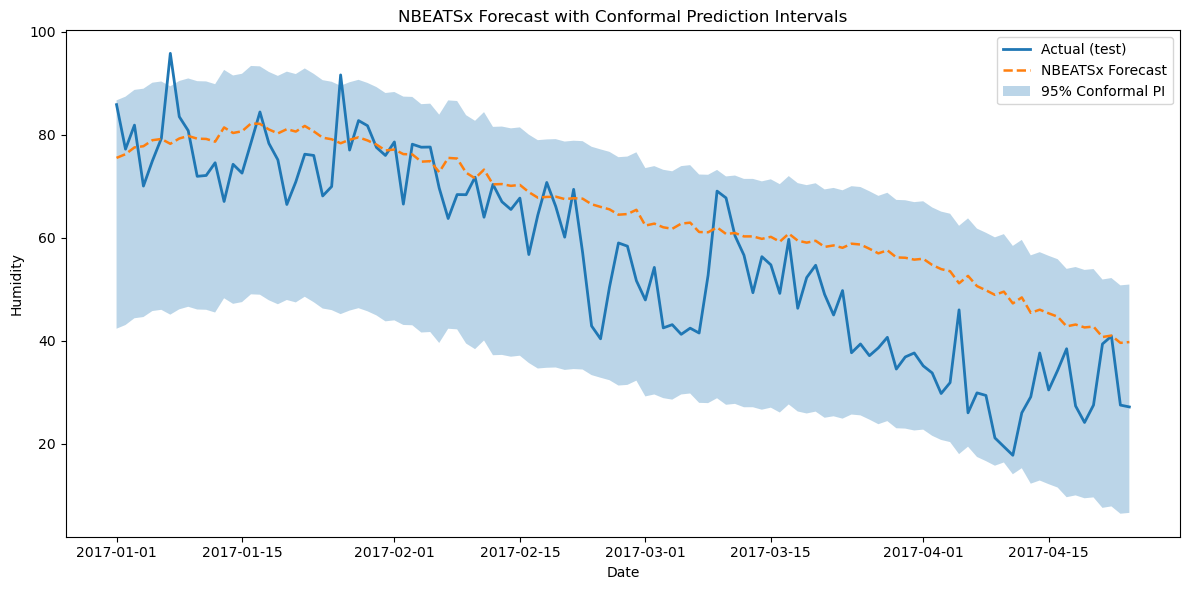

In [10]:
plt.figure(figsize=(12,6))
plt.plot(plot_index, y_true, label="Actual (test)", linewidth=2)
plt.plot(plot_index, yhat_test, label="NBEATSx Forecast", linestyle="--", linewidth=1.8)
plt.fill_between(plot_index, pi_lower, pi_upper, alpha=0.3, label="95% Conformal PI")
plt.title("NBEATSx Forecast with Conformal Prediction Intervals")
plt.xlabel("Date")
plt.ylabel("Humidity")
plt.legend()
plt.tight_layout()
plt.savefig("NBeatsForecastPLOT.png")
plt.show()

## Compute Error Metrics

In [11]:

# -----------------------
# Metrics
# -----------------------
mse   = mean_squared_error(y_true, yhat_test)
mae   = mean_absolute_error(y_true, yhat_test)
rmse = np.sqrt(mse)
cov   = np.mean((y_true >= pi_lower) & (y_true <= pi_upper)) * 100.0

print(f"NBEATSx + Conformal — Test MSE: {mse:.2f} |RMSE: {rmse:.2f}| MAE: {mae:.2f} |  95% PI coverage: {cov:.2f}%")



NBEATSx + Conformal — Test MSE: 166.76 |RMSE: 12.91| MAE: 10.32 |  95% PI coverage: 98.25%
